In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

In [2]:
## Read in our combined dataset (for how data was gathered/aggregated, see other notebook)
tracks = pd.read_csv('./data/tracks.csv').iloc[:, 1:]

In [3]:
## A little under 300,000 observations
tracks.shape

(291630, 19)

In [4]:
tracks.head()

,id,song,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,year,position,top100
0,4TTV7EcfroSLWzXRY6gLv6,Alexander Hamilton,Original Broadway Cast Recording,0.524,0.609,236738.0,0.435,0.0,11.0,0.1180,-7.862,0.0,0.284,131.998,4.0,0.563,2015,NaN,0
1,6dr7ekfhlbquvsVY8D7gyk,"Aaron Burr, Sir",Original Broadway Cast Recording,0.271,0.646,156631.0,0.438,0.0,8.0,0.0945,-10.837,1.0,0.808,160.433,4.0,0.524,2015,NaN,0
2,4cxvludVmQxryrnx1m9FqL,My Shot,Original Broadway Cast Recording,0.150,0.829,333154.0,0.649,0.0,8.0,0.0904,-6.764,1.0,0.317,90.936,4.0,0.569,2015,NaN,0
3,0NJWhm3hUwIZSy5s0TGJ8q,The Story of Tonight,Original Broadway Cast Recording,0.835,0.407,91981.0,0.237,0.0,9.0,0.6480,-10.579,1.0,0.053,95.111,3.0,0.612,2015,NaN,0
4,71X7bPDljJHrmEGYCe7kQ8,The Schuyler Sisters,Original Broadway Cast Recording,0.186,0.740,186543.0,0.727,0.0,2.0,0.6270,-6.253,1.0,0.278,101.408,4.0,0.792,2015,NaN,0


In [5]:
## Check for nulls and drop
removals = tracks[tracks['acousticness'].isnull()].index
tracks[tracks['acousticness'].isnull()]

,id,song,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,year,position,top100
153848,6XFqSSPw9K6EdZO54QghgG,Split Yo Face,Brotha Lynch Hung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999,NaN,0
197382,7Ejk29jo1lKAAQI7UuooAq,We're Gonna Kick It Once,Rodney O & Joe Cooley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,NaN,0


In [6]:
tracks.drop(removals, inplace=True)

In [7]:
## Only 4,521 of the 290,000+ observations are top 100 hits. 
tracks[tracks['top100']==1].shape

(4521, 19)

In [8]:
## Dropping the year variable because I found it to be a potential data leak
tracks.drop(columns=['year'], inplace=True)

In [9]:
##Subset to only the numerical variables
df2 = tracks[['acousticness', 'danceability',
              'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
              'loudness', 'mode', 'speechiness', 'tempo', 'time_signature',
              'valence', 'top100']]

In [10]:
## Going to scale all our features to see how hits differ from non-hits on the same scale
ss = StandardScaler()
scaled_features = pd.DataFrame(ss.fit_transform(df2.drop('top100', axis=1), df2['top100']))
scaled_features = pd.DataFrame(pd.concat([scaled_features, df2['top100']], axis=1))
scaled_features.columns = df2.columns
scaled_features.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,top100
0,0.714325,0.401781,-0.011676,-0.747917,-0.406609,1.620571,-0.540080,0.281681,-1.558545,1.471154,0.399915,0.247227,0.195740,0.0
1,-0.087223,0.619186,-0.784110,-0.735645,-0.406609,0.775555,-0.648399,-0.366737,0.641624,5.493649,1.337197,0.247227,0.041582,0.0
2,-0.470571,1.694461,0.918017,0.127452,-0.406609,0.775555,-0.667297,0.520996,0.641624,1.724479,-0.953583,0.247227,0.219456,0.0
3,1.699626,-0.785135,-1.407499,-1.557837,-0.406609,1.057227,1.902852,-0.310504,0.641624,-0.302121,-0.815965,-1.966343,0.389425,0.0
4,-0.356517,1.171513,-0.495683,0.446512,-0.406609,-0.914478,1.806057,0.632371,0.641624,1.425095,-0.608402,0.247227,1.100923,0.0


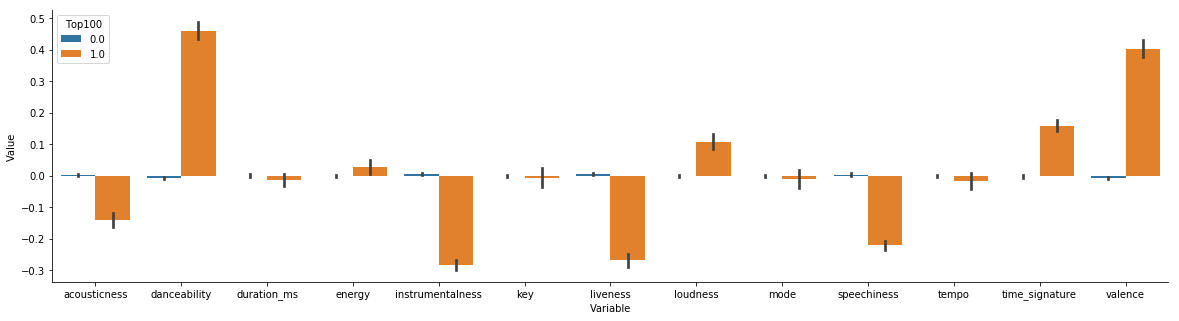

In [11]:
## Let's look at the (scaled) differences between hits and non-hits
fig, ax1 = plt.subplots(figsize=(20,5))
tidy2 = scaled_features.melt(id_vars='top100').rename(columns=str.title)
#tidy3 = tidy2.sample(n=1000)
sns.barplot(x='Variable', y='Value', hue='Top100', data=tidy2, ax=ax1)
sns.despine(fig)

In [12]:
##Lets look at how the mean of each column differs between hits and non-hits
top100 = tracks[tracks['top100']==1]
other = tracks[tracks['top100']==0]
top100_mean = pd.DataFrame(top100.describe().T['mean']) #Mean values of top 100
other_mean = pd.DataFrame(other.describe().T['mean'])   #Mean values of non-hits
compare_means = pd.concat([top100_mean, other_mean], axis=1)
compare_means.columns = ['top100', 'other']
compare_means

,top100,other
acousticness,0.253845,0.299235
danceability,0.619139,0.539385
duration_ms,236487.830790,237971.909518
energy,0.624470,0.617738
instrumentalness,0.029598,0.098727
key,5.223402,5.246971
liveness,0.176781,0.236091
loudness,-8.662994,-9.162115
mode,0.704048,0.708443
speechiness,0.063522,0.092811


## Bootstrapping

### Upsample

In [13]:
tracks.head()

,id,song,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,position,top100
0,4TTV7EcfroSLWzXRY6gLv6,Alexander Hamilton,Original Broadway Cast Recording,0.524,0.609,236738.0,0.435,0.0,11.0,0.1180,-7.862,0.0,0.284,131.998,4.0,0.563,NaN,0
1,6dr7ekfhlbquvsVY8D7gyk,"Aaron Burr, Sir",Original Broadway Cast Recording,0.271,0.646,156631.0,0.438,0.0,8.0,0.0945,-10.837,1.0,0.808,160.433,4.0,0.524,NaN,0
2,4cxvludVmQxryrnx1m9FqL,My Shot,Original Broadway Cast Recording,0.150,0.829,333154.0,0.649,0.0,8.0,0.0904,-6.764,1.0,0.317,90.936,4.0,0.569,NaN,0
3,0NJWhm3hUwIZSy5s0TGJ8q,The Story of Tonight,Original Broadway Cast Recording,0.835,0.407,91981.0,0.237,0.0,9.0,0.6480,-10.579,1.0,0.053,95.111,3.0,0.612,NaN,0
4,71X7bPDljJHrmEGYCe7kQ8,The Schuyler Sisters,Original Broadway Cast Recording,0.186,0.740,186543.0,0.727,0.0,2.0,0.6270,-6.253,1.0,0.278,101.408,4.0,0.792,NaN,0


In [14]:
scaled_features.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,top100
0,0.714325,0.401781,-0.011676,-0.747917,-0.406609,1.620571,-0.540080,0.281681,-1.558545,1.471154,0.399915,0.247227,0.195740,0.0
1,-0.087223,0.619186,-0.784110,-0.735645,-0.406609,0.775555,-0.648399,-0.366737,0.641624,5.493649,1.337197,0.247227,0.041582,0.0
2,-0.470571,1.694461,0.918017,0.127452,-0.406609,0.775555,-0.667297,0.520996,0.641624,1.724479,-0.953583,0.247227,0.219456,0.0
3,1.699626,-0.785135,-1.407499,-1.557837,-0.406609,1.057227,1.902852,-0.310504,0.641624,-0.302121,-0.815965,-1.966343,0.389425,0.0
4,-0.356517,1.171513,-0.495683,0.446512,-0.406609,-0.914478,1.806057,0.632371,0.641624,1.425095,-0.608402,0.247227,1.100923,0.0


In [15]:
scaled_features.dropna(inplace=True)

In [16]:
df_majority = tracks[tracks['top100']==0]

In [17]:
df_minority = tracks[tracks['top100']==1]

In [18]:
##Code from https://elitedatascience.com/imbalanced-classes
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=13) # reproducible results

In [19]:
##Minority class (top 100 hits) has been upsampled to match the majority class (non-hits)
df_minority_upsampled.shape

(287107, 18)

In [20]:
##Combine the two datasets back together
tracks_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [21]:
## Now we have 574,218 observations, 50% hits and 50% non-hits
tracks_upsampled.shape

(574214, 18)

### Downsample

In [22]:
##Code from https://elitedatascience.com/imbalanced-classes
df_majority_downsampled = resample(df_majority, 
                                 replace=False,                     # sample with replacement
                                 n_samples=df_minority.shape[0],    # to match minority class
                                 random_state=13)                   # reproducible results

In [23]:
## Majority class (non-hits) has been downsampled to match the minority class (top 100 hits)
df_majority_downsampled.shape

(4521, 18)

In [24]:
##Combine the two datasets back together
tracks_downsampled = pd.concat([df_minority, df_majority_downsampled])

In [25]:
## Now we have 9,042 observations, 50% hits and 50% non-hits
tracks_downsampled.shape

(9042, 18)

### SMOTE

In [26]:
## From https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas/43982712
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X = tracks.select_dtypes(include=numerics)
y = X['top100']
try:
    X.drop(['top100', 'position'], axis=1, inplace=True)
except:
    X.drop(['top100'], axis=1, inplace=True)



/Users/jcacho/anaconda3/envs/DSI/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [27]:
## Synthetic Minority Oversampling Technique
## We are running this because of our 290,000+ observations, only about ~5,000 are in the minority class
## This type of imbalance will bias the model too heavily
sm = SMOTE()
X_res, y_res = sm.fit_resample(X, y)

In [28]:
y.mean()

0.015502626633930898

In [29]:
y_res.mean()

0.5

## Train/Test Split

In [30]:
# ## From https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas/43982712
# numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# X = tracks_upsampled.select_dtypes(include=numerics)
# y = X['top100']
# X.drop(['top100', 'position'], axis=1, inplace=True)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, random_state=13)

## Logistic Regression

In [32]:
## Training a Logistic Regression model for baseline accuracy
logreg = LogisticRegression()

# Train model
logreg.fit(X_train, y_train)
 
# Predict on training set
pred_train = logreg.predict(X_train)
pred_test = logreg.predict(X_test)

/Users/jcacho/anaconda3/envs/DSI/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
##Training Accuracy
print(accuracy_score(pred_train, y_train))

0.660086843449589


In [34]:
##Testing Accuracy
print(accuracy_score(pred_test, y_test))

0.656540395948563


In [35]:
logreg_score = accuracy_score(pred_test, y_test)

## KNN

In [36]:
knn_class = KNeighborsClassifier()
knn_class.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [37]:
# Predict on training set
pred_train = knn_class.predict(X_train)
pred_test = knn_class.predict(X_test)

In [38]:
##Training Accuracy
print(accuracy_score(pred_train, y_train))

##Testing Accuracy
print(accuracy_score(pred_test, y_test))

0.8783216458459109
0.8226869331401424


In [39]:
knn_score = accuracy_score(pred_test, y_test)

## Decision Tree Classifier

In [40]:
cart_class = DecisionTreeClassifier()
cart_class.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [41]:
# Predict on training set
pred_train = cart_class.predict(X_train)
pred_test = cart_class.predict(X_test)

In [42]:
##Training Accuracy
print(accuracy_score(pred_train, y_train))

##Testing Accuracy
print(accuracy_score(pred_test, y_test))

0.9998699670273533
0.9700530810705379


In [43]:
dt_score = accuracy_score(pred_test, y_test)

In [44]:
coefficients = pd.Series(cart_class.feature_importances_)
features = pd.Series(X.columns)
pd.concat([features, coefficients], axis=1)

,0,1
0,acousticness,0.057796
1,danceability,0.083011
2,duration_ms,0.043706
3,energy,0.027039
4,instrumentalness,0.016315
5,key,0.416784
6,liveness,0.018358
7,loudness,0.012972
8,mode,0.222744
9,speechiness,0.033610


In [45]:
tracks_upsampled['top100'].value_counts()

1    287107
0    287107
Name: top100, dtype: int64

## Bagged Classifier

In [46]:
bagged_class = BaggingClassifier()
bagged_class.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [47]:
# Predict on training set
pred_train = bagged_class.predict(X_train)
pred_test = bagged_class.predict(X_test)

In [48]:
##Training Accuracy
print(accuracy_score(pred_train, y_train))

##Testing Accuracy
print(accuracy_score(pred_test, y_test))

0.9981795383829472
0.9864789556543182


In [49]:
bag_score = accuracy_score(pred_test, y_test)

## Random Forest

In [50]:
random_forest_class = RandomForestClassifier()
random_forest_class.fit(X_train, y_train)

/Users/jcacho/anaconda3/envs/DSI/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [51]:
# Predict on training set
pred_train = random_forest_class.predict(X_train)
pred_test = random_forest_class.predict(X_test)

In [52]:
##Training Accuracy
print(accuracy_score(pred_train, y_train))

##Testing Accuracy
print(accuracy_score(pred_test, y_test))

0.9988041610551247
0.9817559942599997


In [53]:
rf_score = accuracy_score(pred_test, y_test)

In [54]:
coefficients = pd.Series(random_forest_class.feature_importances_)
features = pd.Series(X.columns)
pd.concat([features, coefficients], axis=1)

,0,1
0,acousticness,0.112218
1,danceability,0.070404
2,duration_ms,0.056180
3,energy,0.057870
4,instrumentalness,0.043434
5,key,0.214133
6,liveness,0.042887
7,loudness,0.035769
8,mode,0.170644
9,speechiness,0.061317


## Adaboost

In [55]:
adaboost_class = AdaBoostClassifier()
adaboost_class.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [56]:
# Predict on training set
pred_train = adaboost_class.predict(X_train)
pred_test = adaboost_class.predict(X_test)

In [57]:
##Training Accuracy
print(accuracy_score(pred_train, y_train))

##Testing Accuracy
print(accuracy_score(pred_test, y_test))

0.8604490781591047
0.858624629059448


In [58]:
ada_score = accuracy_score(pred_test, y_test)

## Gradient Boosting Classifier

In [59]:
gradient_class = GradientBoostingClassifier()
gradient_class.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [60]:
# Predict on training set
pred_train = gradient_class.predict(X_train)
pred_test = gradient_class.predict(X_test)

In [61]:
##Training Accuracy
print(accuracy_score(pred_train, y_train))

##Testing Accuracy
print(accuracy_score(pred_test, y_test))

0.9510913481632842
0.9511055073352188


In [62]:
gb_score = accuracy_score(pred_test, y_test)

## Voting Classifier

In [63]:
vc = VotingClassifier([('rfc', RandomForestClassifier()), 
                       ('abc', AdaBoostClassifier()), 
                       ('gbc', GradientBoostingClassifier()), 
                       ('dtc', DecisionTreeClassifier()), 
                       ('bag', BaggingClassifier())])

In [64]:
vc.fit(X_train, y_train)
vc.score(X_train, y_train)

/Users/jcacho/anaconda3/envs/DSI/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.998195792504528

In [65]:
vc.score(X_test, y_test)

0.9842567953522716

In [66]:
vc_score = accuracy_score(pred_test, y_test)